In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [47]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

In [48]:
# Limit the number of samples per class to 1000, there are 10 classes (0 to 9)
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

In [49]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a
     

In [50]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
     

In [51]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)
     

In [52]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()
     

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

/home/la9631/miniconda3/envs/firstenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [54]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 100):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

     

====> Epoch: 1 Average loss: -59.4254
====> Test set loss: -47.6218
====> Epoch: 2 Average loss: -45.8168
====> Test set loss: -42.4733
====> Epoch: 3 Average loss: -41.2129
====> Test set loss: -39.6496
====> Epoch: 4 Average loss: -38.7063
====> Test set loss: -37.6042
====> Epoch: 5 Average loss: -37.2773
====> Test set loss: -36.8732
====> Epoch: 6 Average loss: -36.5262
====> Test set loss: -36.2822
====> Epoch: 7 Average loss: -36.1051
====> Test set loss: -35.9263
====> Epoch: 8 Average loss: -35.8395
====> Test set loss: -35.5360
====> Epoch: 9 Average loss: -35.4251
====> Test set loss: -35.3011
====> Epoch: 10 Average loss: -35.1393
====> Test set loss: -35.0043
====> Epoch: 11 Average loss: -34.8701
====> Test set loss: -34.7990
====> Epoch: 12 Average loss: -34.6078
====> Test set loss: -34.5782
====> Epoch: 13 Average loss: -34.3971
====> Test set loss: -34.2987
====> Epoch: 14 Average loss: -34.1840
====> Test set loss: -34.2400
====> Epoch: 15 Average loss: -34.0250
====

In [12]:
torch.save(model.state_dict(), 'vae.pth')

In [13]:
pwd

'/home/la9631/HW2/test'

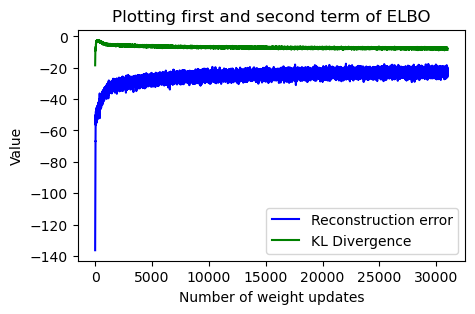

In [55]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()
    

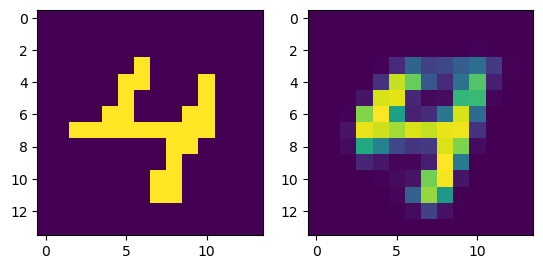

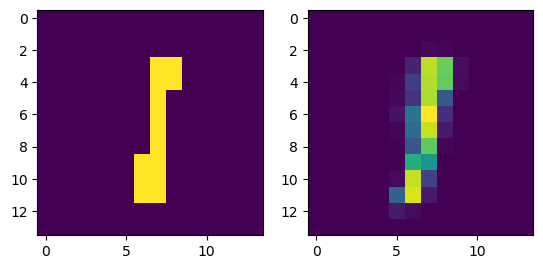

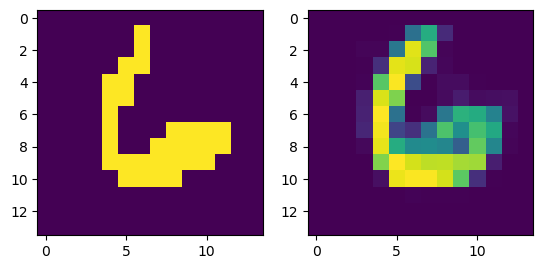

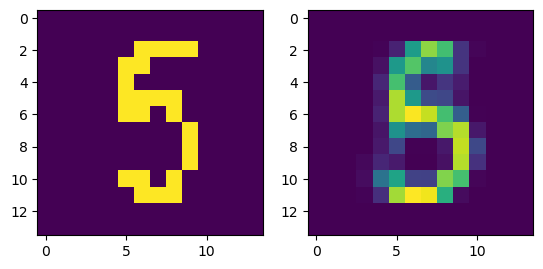

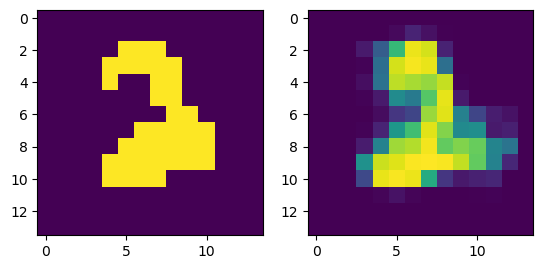

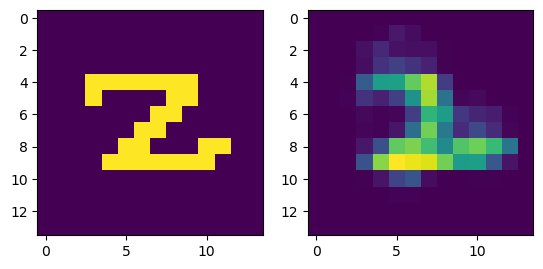

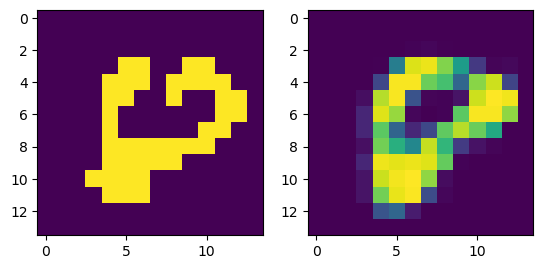

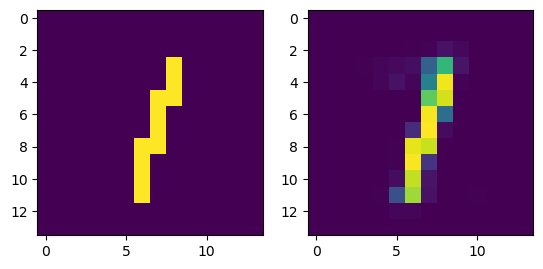

In [56]:
model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

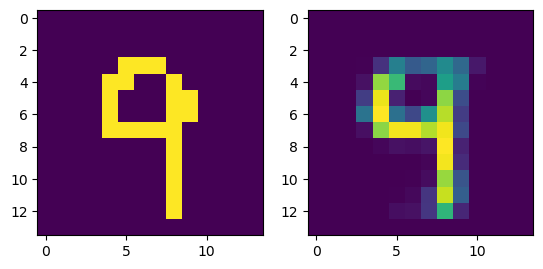

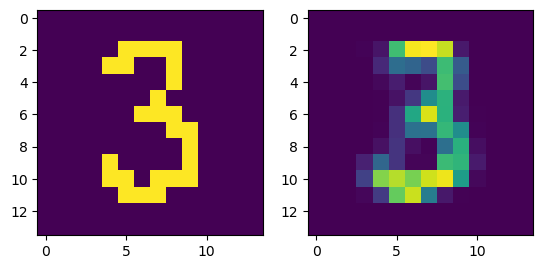

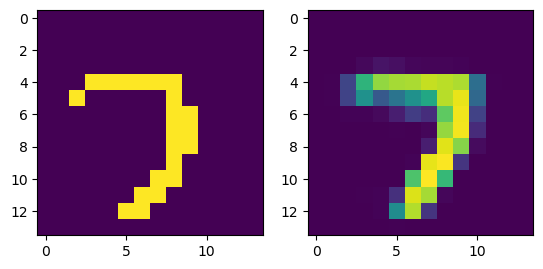

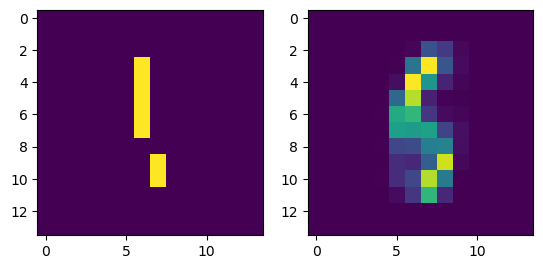

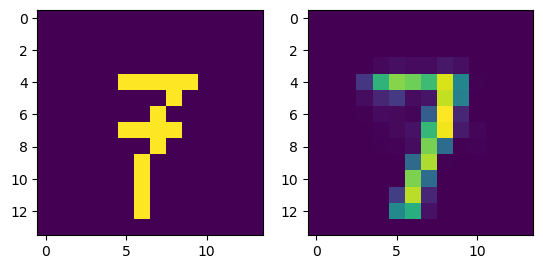

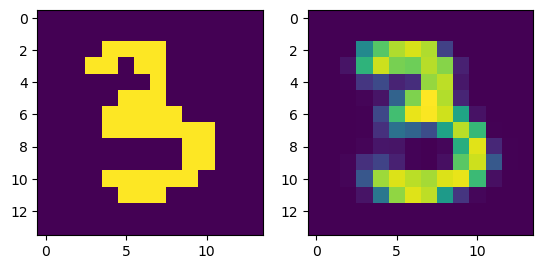

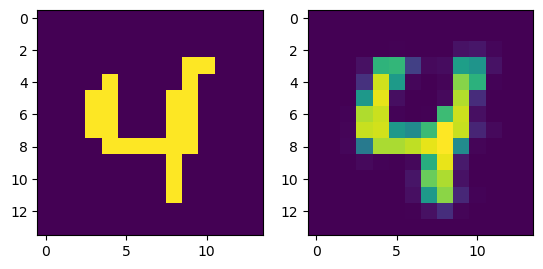

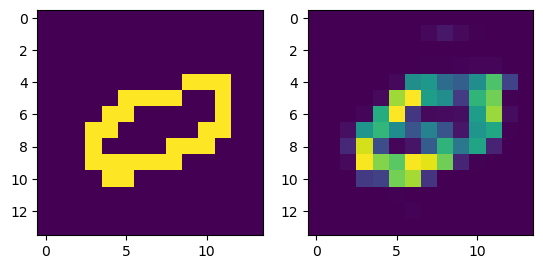

In [57]:
model.eval()
for i in range(8):
  a,t = next(iter(testloader))
  a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

tensor([-0.1769, -2.7197, -0.2704,  0.4398,  0.5427, -0.4498, -0.7562,  0.7023],
       device='cuda:0')
tensor([-1.4079, -0.7219,  1.1635,  0.9335, -0.5138, -1.3189, -0.2242, -2.1829],
       device='cuda:0')
tensor([ 1.0336,  0.7695, -1.0100, -0.1611,  1.3940,  0.5034,  0.1155,  0.2166],
       device='cuda:0')
tensor([-0.2543,  0.4773, -0.8380, -2.2478,  0.1300,  2.0075, -0.5902,  1.2994],
       device='cuda:0')
tensor([ 0.8530, -1.3777,  0.4272, -2.3680, -1.4066,  1.5352,  0.0092, -0.9348],
       device='cuda:0')
tensor([ 1.3164, -0.0488, -0.3579, -0.4066, -0.8256, -1.6079,  1.0647,  1.8873],
       device='cuda:0')
tensor([-0.9819, -0.2430,  1.3853,  0.4276, -0.5235, -0.9663, -0.8378,  0.2529],
       device='cuda:0')
tensor([-1.2247,  0.5272, -0.0668, -0.2018, -1.2289, -0.0661,  0.2347,  0.2974],
       device='cuda:0')


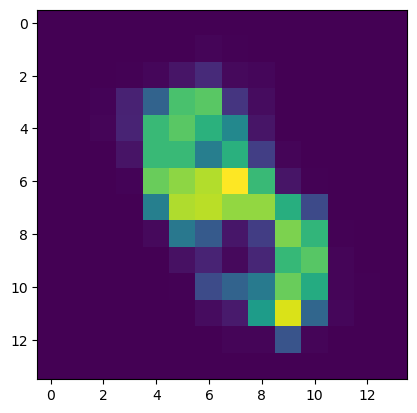

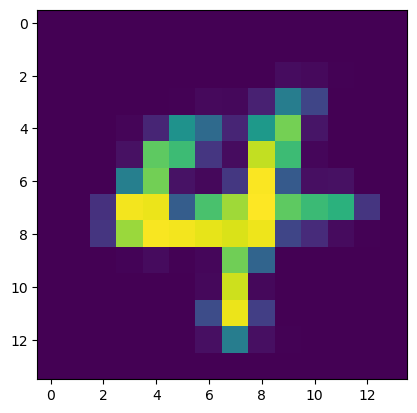

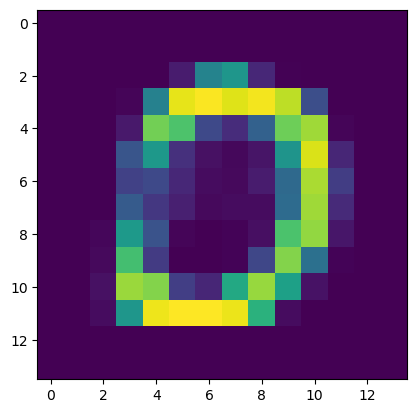

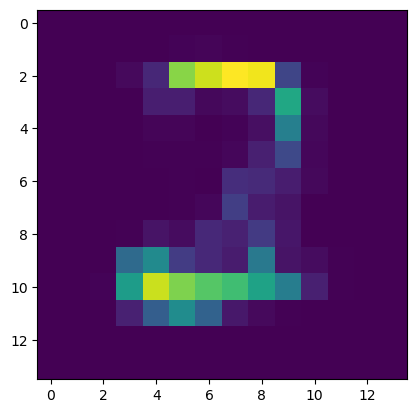

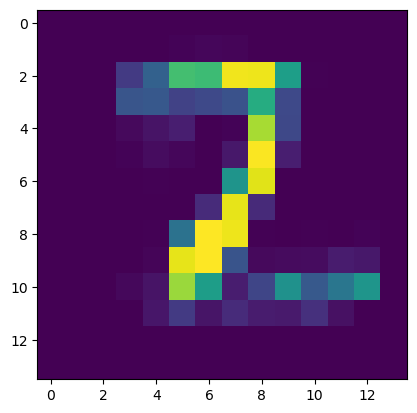

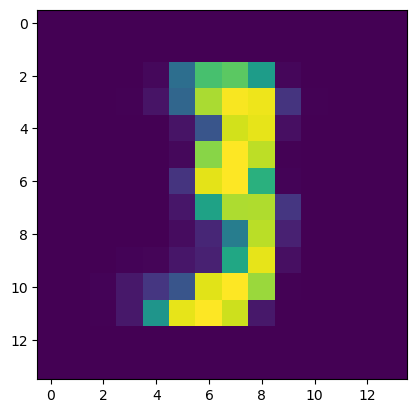

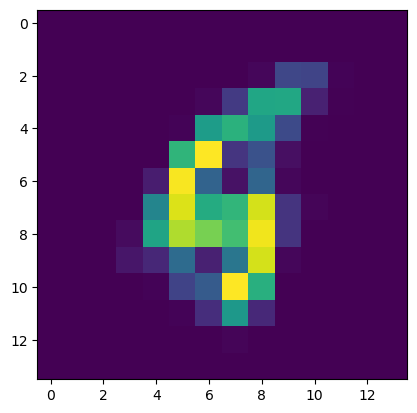

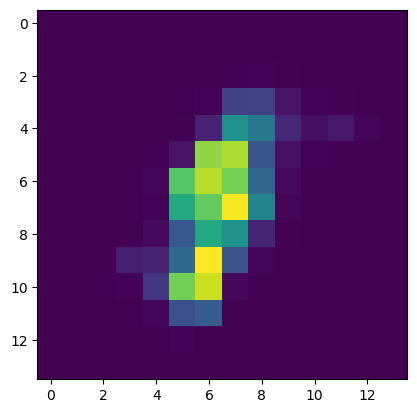

In [58]:
for i in range(8):
  
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  x= x.cuda()
  recon = model.decoder(x)
  b = recon.reshape((14,14))
  print(x)
  f, axarr = plt.subplots(1) 
  axarr.imshow(b.detach().cpu().numpy())

309 309
<class 'list'>
<class 'list'>
True
True


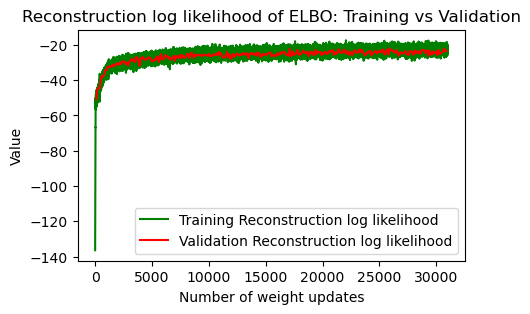

In [59]:
print(len(update), len(testl))
print(type(update))
print(type(testl))

for i, element in enumerate(testl):
    if isinstance(element, torch.Tensor):
        testl[i] = element.item()


print(all(isinstance(i, (int, float)) for i in update))
print(all(isinstance(i, (int, float)) for i in testl))
for i, element in enumerate(testl):
    if not isinstance(element, (int, float)):
        print(f"Non-numeric element at index {i}: {element} (type: {type(element)})")


plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')
plt.plot(update, testl, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()


In [73]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                           transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                          transform=transforms.ToTensor())

# Add Gaussian noise
def add_noise(image, std=0.2):
    return image + torch.randn_like(image) * std

# Apply noise transformation
train_dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    add_noise
])

test_dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    add_noise
])

# Create data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [74]:
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()
r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a
x_val = np.where(x_val > 128, 1, 0)
x_val = x_val.astype(np.float32)


batch_size = 32
test_loader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)


In [75]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

In [76]:
model = VAE()
model.load_state_dict(torch.load('vae.pth', weights_only=True))
model.eval()


VAE(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=8, bias=True)
  (fc22): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=196, bias=True)
)

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [78]:
def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = 0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

In [79]:
test_loss= 0
model = model
recon_val = []
epoch = [i for i in range(10)]
with torch.no_grad():
    for data, _ in test_loader:
        # data = data.cuda()
        recon, mu, std = model(data)
        loss, err, kld = loss_function(recon, data, mu, std)
        
        test_loss += err + kld
        recon_val.append(err.item()/100)

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

====> Test set loss: -16.5273


In [80]:
bsize

16

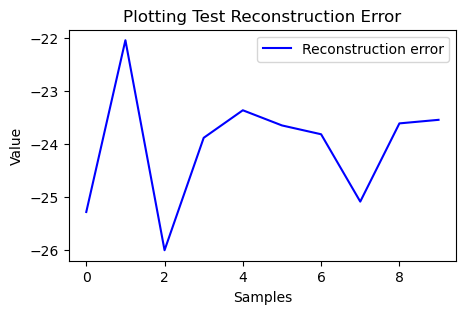

In [81]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(epoch, recon_val, 'b', label='Reconstruction error')
# plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting Test Reconstruction Error')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()

In [82]:
len(test_loader) * 100

1000

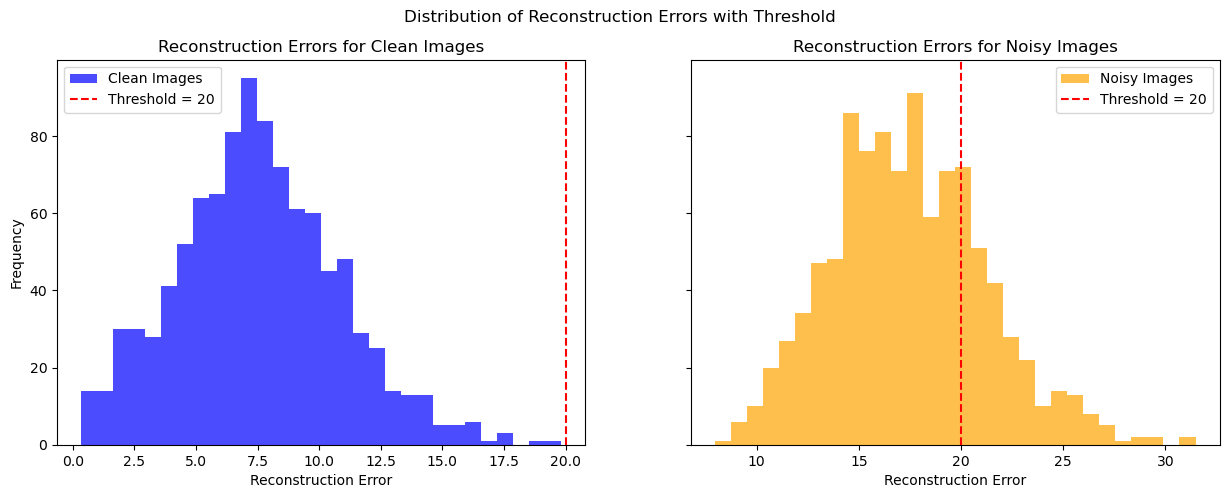

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate reconstruction error as a tensor
def calculate_reconstruction_error(data, recon):
    return torch.sum((data - recon) ** 2, dim=1)

# Initialize lists to store reconstruction errors
clean_errors = []
noisy_errors = []

# Set threshold for anomaly detection
threshold = 20

# Evaluation loop
model.eval()
model = model.to(device)
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)  # Ensure data is on the correct device

        # Get reconstruction error for clean image
        recon_clean, _, _ = model(data.view(-1, 196).to(device))  # Ensure model output is on the same device
        error_clean = calculate_reconstruction_error(data.view(-1, 196), recon_clean)
        clean_errors.extend(error_clean.cpu().numpy())  # Move to CPU for numpy

        # Add noise and pass noisy image through model
        noisy_data = add_noise(data).to(device)  # Ensure noisy data is on the correct device
        recon_noisy, _, _ = model(noisy_data.view(-1, 196).to(device))  # Ensure model output is on the same device
        error_noisy = calculate_reconstruction_error(noisy_data.view(-1, 196), recon_noisy)
        noisy_errors.extend(error_noisy.cpu().numpy())  # Move to CPU for numpy

# Create a horizontal plot layout
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot reconstruction errors for clean images
axes[0].hist(clean_errors, bins=30, alpha=0.7, color='blue', label='Clean Images')
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
axes[0].set_title('Reconstruction Errors for Clean Images')
axes[0].set_xlabel('Reconstruction Error')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot reconstruction errors for noisy images
axes[1].hist(noisy_errors, bins=30, alpha=0.7, color='orange', label='Noisy Images')
axes[1].axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
axes[1].set_title('Reconstruction Errors for Noisy Images')
axes[1].set_xlabel('Reconstruction Error')
axes[1].legend()

plt.suptitle('Distribution of Reconstruction Errors with Threshold')
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

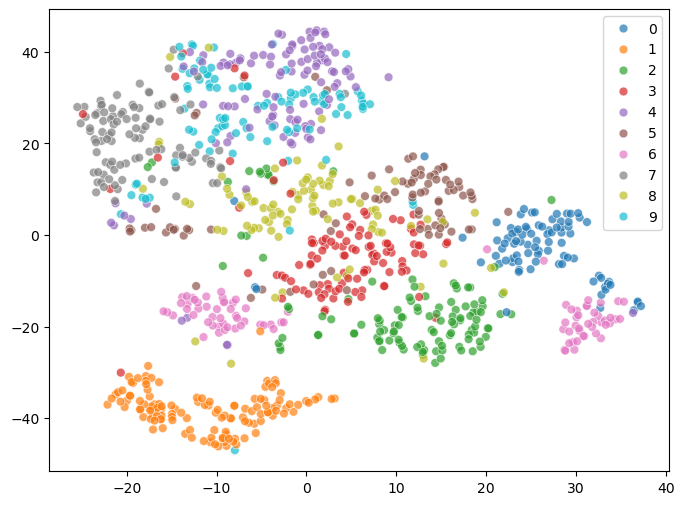

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Function to perform t-SNE on the VAE's latent space
def visualize_tsne_latent_space(model, dataloader, num_points=1000, random_seed=42):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.to(device)
            mu, _ = model.encoder(data.view(-1, 196))  # Obtain the latent mean
            latent_vectors.append(mu.cpu().numpy())
            labels.append(target.cpu().numpy())

            # Limit number of points for t-SNE
            if len(latent_vectors) * data.size(0) >= num_points:
                break

    # Flatten lists of latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors)[:num_points]
    labels = np.concatenate(labels)[:num_points]

    # Apply t-SNE to the latent vectors
    tsne = TSNE(n_components=2, random_state=random_seed)
    tsne_result = tsne.fit_transform(latent_vectors)

    # Plotting the 2D t-SNE result
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='tab10', alpha=0.7, s=40)
    plt.colorbar(label="Digit Class")
    plt.title("t-SNE Visualization of the Latent Space")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Classes", loc="best", bbox_to_anchor=(1, 1))
    plt.show()

# Using the function to visualize the latent space with t-SNE
visualize_tsne_latent_space(model, testloader, num_points=1000)
